In [1]:
# Import Data Manipulation Libaries
import pandas as pd 
import numpy as np 

# Import Data Visualization Libraries
import seaborn as sns 
import matplotlib.pyplot as plt 

# Import Filter Warning Libraries
import warnings
warnings.filterwarnings(action = 'ignore')

# Import Scikit-learn Libraries
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from collections import OrderedDict
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score,KFold

# Import Machine Learning Model Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Multicolinearity test and treatment libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

# Import Neccessory libraries
import optuna 
import researchpy 

In [5]:
filepath = 'https://raw.githubusercontent.com/rushikeshpatil-123/heartdisese_predictionmodel/refs/heads/main/data/raw/heart.csv'

target = "target"

numerical_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

categorical_columns = []


df = pd.read_csv(filepath)

# Segregate Numerical and Categorical Columns

numerical_col = df.select_dtypes(exclude = "object").columns
categorical_col = df.select_dtypes(include = "object").columns

Winsorized column: age
Winsorized column: sex
Winsorized column: cp
Winsorized column: trestbps
Winsorized column: chol
Winsorized column: fbs
Winsorized column: restecg
Winsorized column: thalach
Winsorized column: exang
Winsorized column: oldpeak
Winsorized column: slope
Winsorized column: ca
Winsorized column: thal
Winsorized column: target


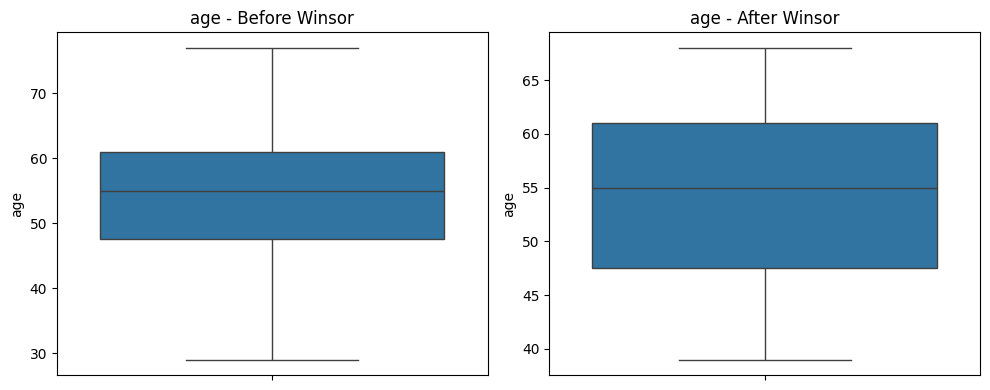

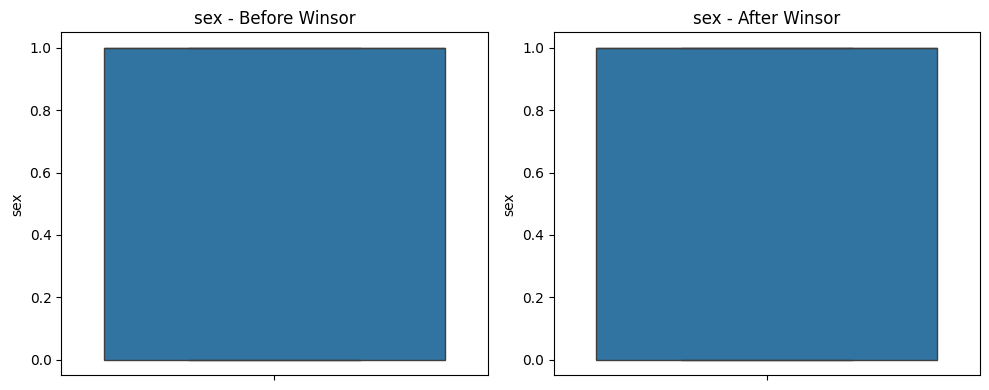

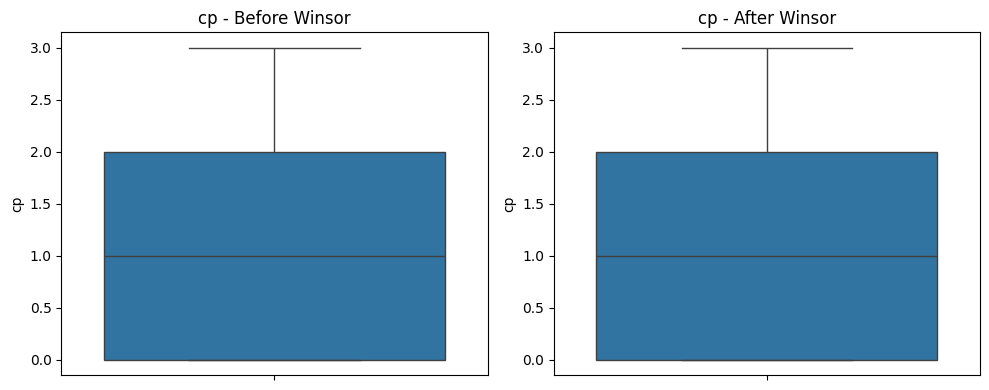

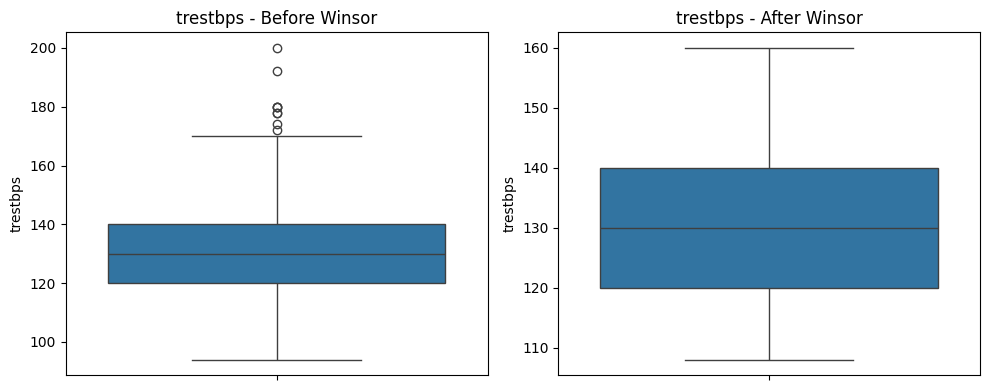

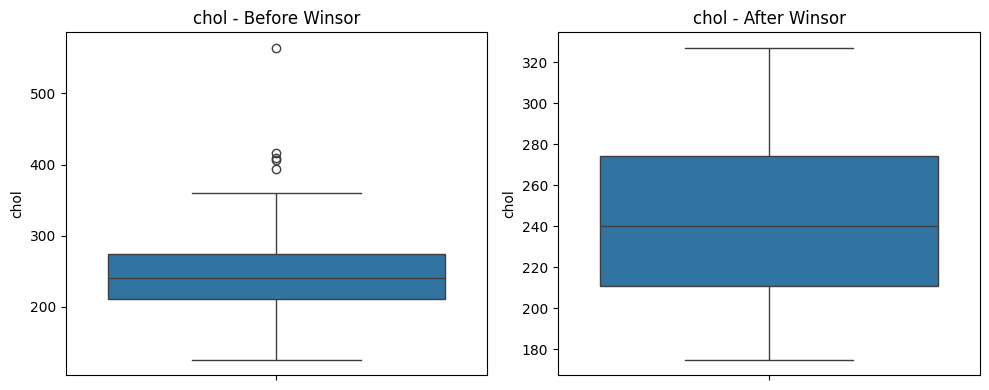

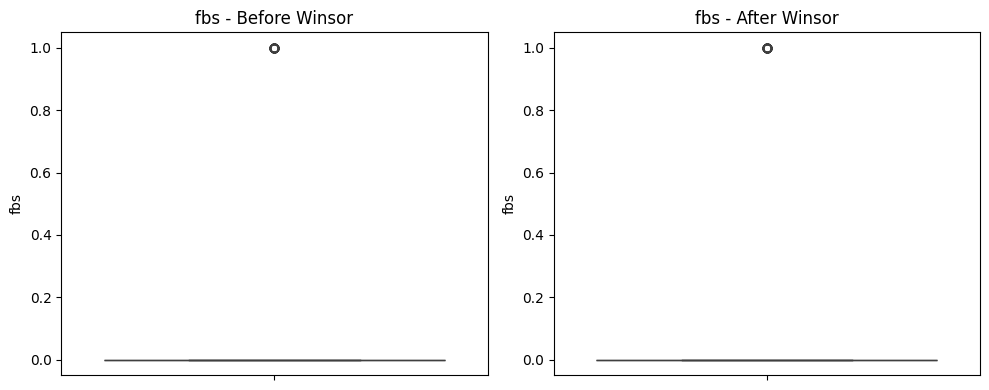

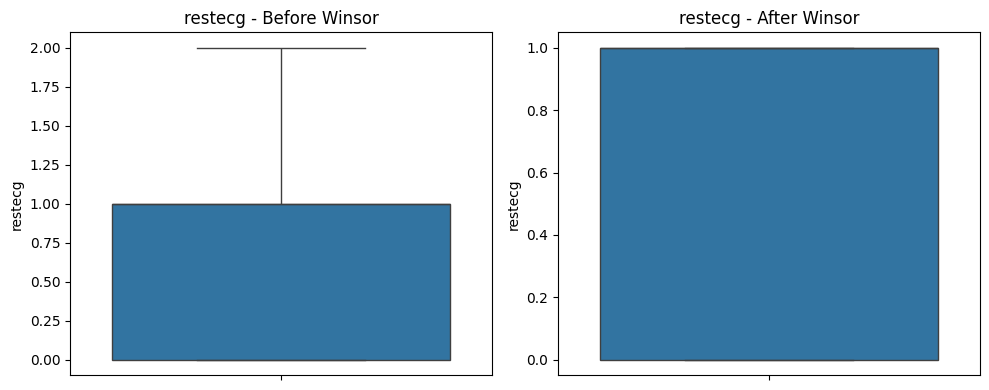

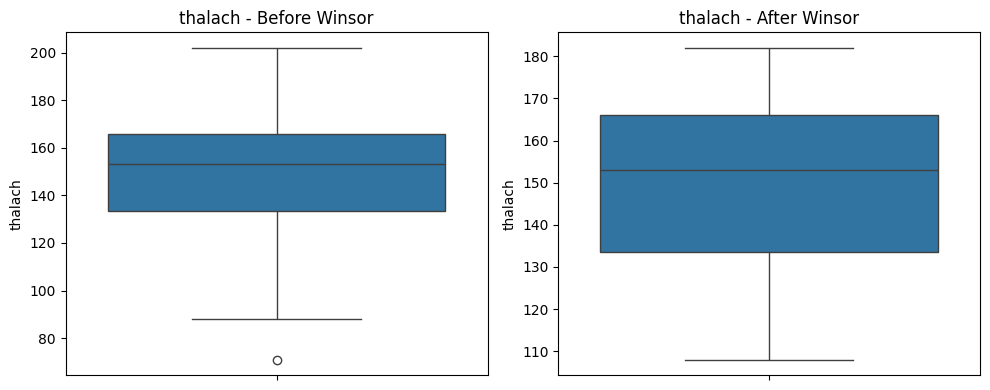

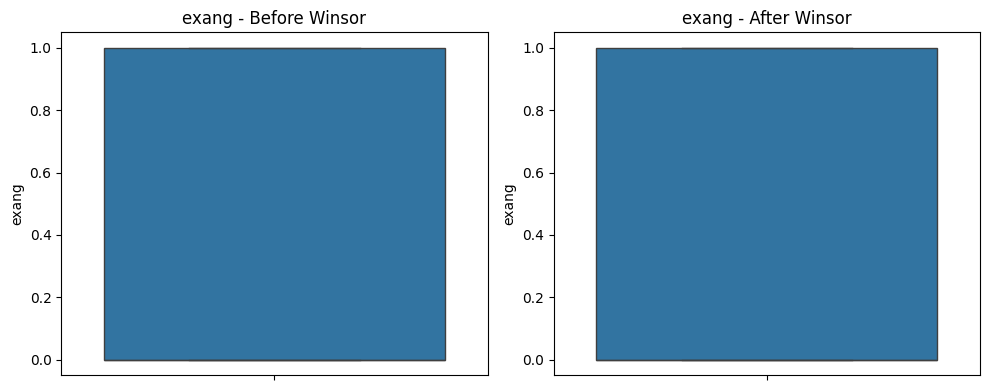

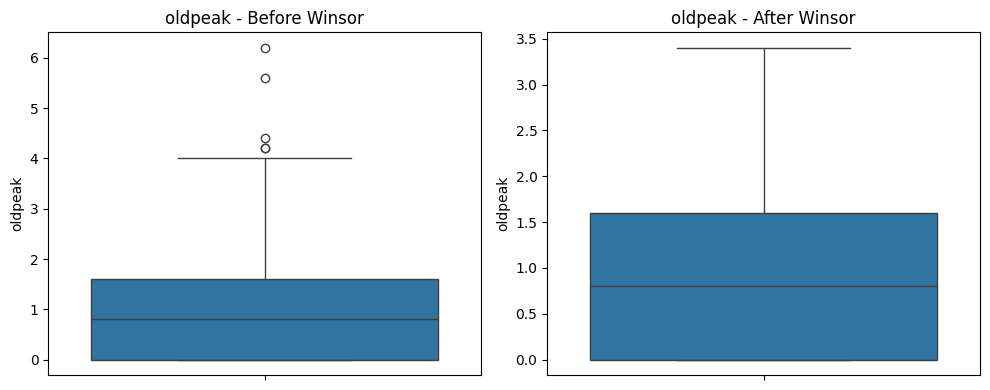

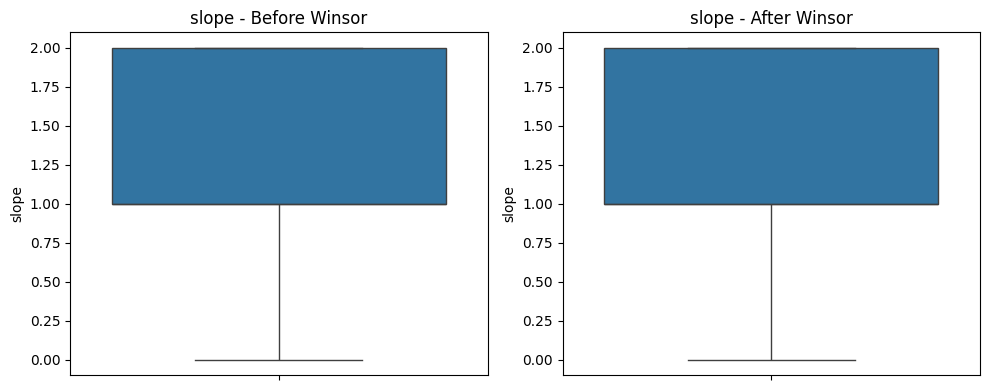

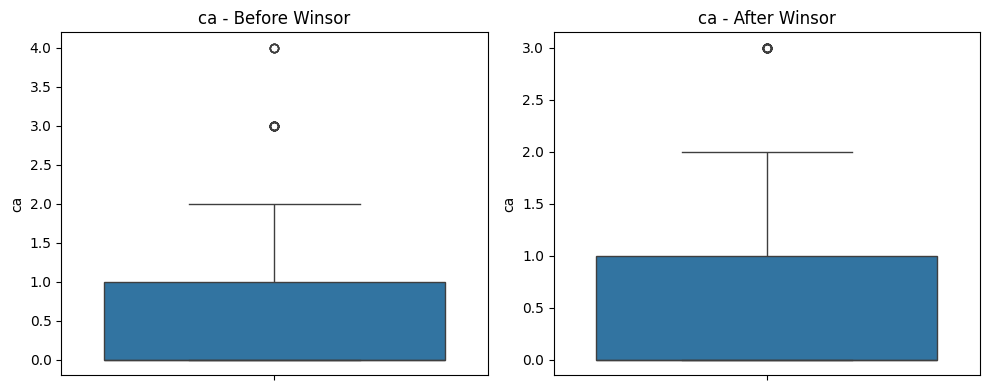

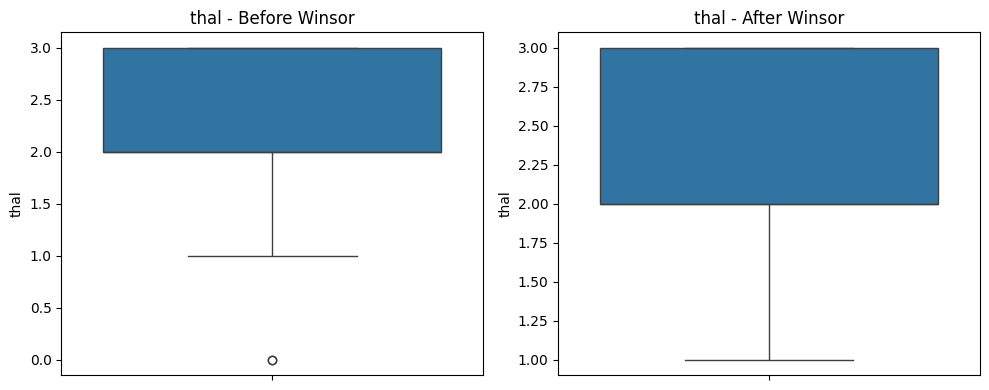

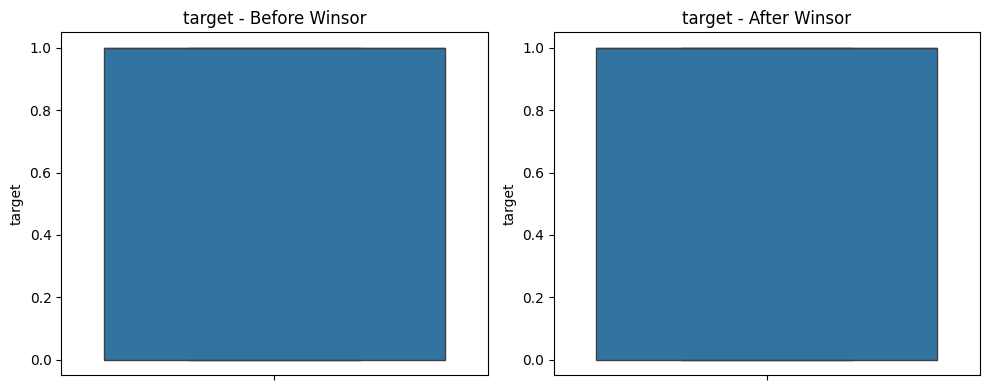

In [6]:
from scipy.stats.mstats import winsorize

# Create copy before winsorization
df_before_winsor = df.copy()

# Apply winsorization
for col in numerical_col:
    df[col] = winsorize(
        df[col],
        limits=(0.05, 0.05)  # 5% lower & upper capping
    )
    
    print(f"Winsorized column: {col}")

# Performance checking 

for col in numerical_col:
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    sns.boxplot(y=df_before_winsor[col])
    plt.title(f"{col} - Before Winsor")

    plt.subplot(1,2,2)
    sns.boxplot(y=df[col])
    plt.title(f"{col} - After Winsor")

    plt.tight_layout()
    plt.show()


In [4]:
def split_data(data, target, test_size = 0.3, random_state = 42):
    
    X = data.drop(columns= [target],axis=1)
    y = data[target]

    categorical_columns = X.select_dtypes(include = "object").columns
    numerical_columns = X.select_dtypes(exclude = "object").columns

    numerical_pipeline = Pipeline(steps = [
        ("imputer",SimpleImputer(strategy="median")),
        ("scaler",RobustScaler()),
        ("pca", PCA(n_components=0.95))
    ])
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("num",numerical_pipeline, numerical_columns),
        ("cat",categorical_pipeline,categorical_columns)
    ])

    X_train, X_test, y_train ,y_test = train_test_split(
        X,y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train,X_test, y_train, y_test

In [22]:
def model_building():
    models = OrderedDict({
        "LogisticRegression": LogisticRegression(max_iter= 1000),
        "RandomForestClassifier":RandomForestClassifier(),
        "DecisionTreeClassifier":DecisionTreeClassifier(),
        "KNeighborsClassifier":KNeighborsClassifier(),
        "SVC":SVC()
    })
    return models

In [26]:
def evaluate_model(data, target):
    
    X_train, X_test, y_train, y_test = split_data(data, target)
    models = model_building()
    
    results = []
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append((model_name, accuracy))
    
    return results,X_train, X_test, y_train, y_test

In [27]:
results,X_train, X_test, y_train, y_test = evaluate_model(df, target="target")

for model, acc in results:
    print(f"{model}: {acc:.4f}")

LogisticRegression: 0.8022
RandomForestClassifier: 0.8242
DecisionTreeClassifier: 0.7363
KNeighborsClassifier: 0.7912
SVC: 0.8022


In [29]:
# use randomforestclassifier as final model
final_model = RandomForestClassifier()
final_model.fit(X_train,y_train)
y_final_pred = final_model.predict(X_test)

# Use Kfold Cross Validation to check the final Model Performance
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(final_model, X_train, y_train, cv= kfold, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_results}")

Cross-Validation Accuracy Scores: [0.8372093  0.8372093  0.78571429 0.76190476 0.83333333]


In [30]:
# Use RandomizedSearchCV as Hyper Parameter Tuning Technique
param_dist = {
    'n_estimators' : [50,100,200],
    'max_depth':[None,10,20,30],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1,2,4],
    'bootstrap':[True, False]
}
random_search = RandomizedSearchCV(
    estimator=final_model,
    param_distributions=param_dist,
    n_iter = 10,
    cv = 5,
    verbose = 2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_tuned_pred = best_model.predict(X_test)
print("Best Hyperparameters:",random_search.best_params_)
print("Tuned Model Accuracy:", accuracy_score(y_test,y_tuned_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': True}
Tuned Model Accuracy: 0.8241758241758241


In [32]:
# Using Grid =SearchCV as Hyper Paramater Tuning Technique
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf' :[1,2],
    'bootstrap' :[True, False]
}
grid_search = GridSearchCV(
    estimator=final_model,
    param_grid=param_grid,
    cv = 5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train,y_train)
best_grid_model = grid_search.best_estimator_
y_grid_pred = best_grid_model.predict(X_test)
print("Best Hyperparameters:", grid_search.best_params_)
print("Grid Search Model Accuracy: ", accuracy_score(y_test, y_grid_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Grid Search Model Accuracy:  0.8241758241758241


In [33]:
def objective(trial):
    
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        max_depth=trial.suggest_int("max_depth", 5, 30),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
        bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
        random_state=42,
        n_jobs=-1
    )
    
    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv = 5,
        scoring="accuracy"

    ).mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_optuna_model = RandomForestClassifier(
    **study.best_params,
    random_state=42,
    n_jobs = -1
)
best_optuna_model.fit(X_train, y_train)

[I 2026-01-03 13:53:11,064] A new study created in memory with name: no-name-9850c45f-a9a1-47f1-9684-8d3dec2ae947
[I 2026-01-03 13:53:13,279] Trial 0 finished with value: 0.8117386489479512 and parameters: {'n_estimators': 246, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.8117386489479512.
[I 2026-01-03 13:53:15,713] Trial 1 finished with value: 0.8260243632336655 and parameters: {'n_estimators': 256, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 1 with value: 0.8260243632336655.
[I 2026-01-03 13:53:16,967] Trial 2 finished with value: 0.7976744186046513 and parameters: {'n_estimators': 141, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 0.8260243632336655.
[I 2026-01-03 13:53:18,134] Trial 3 finished with value: 0.7976744186046512 and parameters: {'n_estimators': 107, 'max_depth': 9, 'min_samples_spli

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",256
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",7
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",4
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [34]:
y_optuna_pred = best_optuna_model.predict(X_test)

print("Best Hyperparameters:", study.best_params)
print("Optuna Test Accuracy:", accuracy_score(y_test, y_optuna_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_optuna_pred))

Best Hyperparameters: {'n_estimators': 256, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': True}
Optuna Test Accuracy: 0.8131868131868132

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.68      0.77        41
           1       0.78      0.92      0.84        50

    accuracy                           0.81        91
   macro avg       0.83      0.80      0.81        91
weighted avg       0.82      0.81      0.81        91

